In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
import tensorflow as tf

2023-10-25 11:11:10.680301: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
train = pd.read_csv('./movie_reviews.csv')
test = pd.read_csv('./test_data.csv', index_col='Id')

In [8]:
train

,text,label
0,If you havent seen this movie than you need to...,1
1,but Cinderella gets my vote not only for the w...,0
2,This movie is pretty cheesy but I do give it c...,1
3,I have not seen a Van Damme flick for a while ...,1
4,This is a sleeper It defines Nicholas Cage The...,1
...,...,...
39995,This movie is inspiring to anyone who is or ha...,1
39996,This film hits the heart with a reality like n...,1
39997,East Side Story is a documentary of musical co...,1
39998,And a selfadmitted one to boot At one point th...,0


In [9]:
test

,text
Id,
0,What can possibly said about this movie other ...
1,I dont care how many bad reviews purple rain g...
2,Ken Russell directed this weird Not very ero...
3,This is a great movie from the lost age of rea...
4,I have a problem with the movie snobs who cons...
...,...
9995,I first saw this on Thames television and love...
9996,There are rumours that a fourth Underworld is ...
9997,Jag är nyfiken Yellow is a lot of fun Like at...


In [20]:
y = train.label
X = train.text

0    20049
1    19951
Name: label, dtype: int64


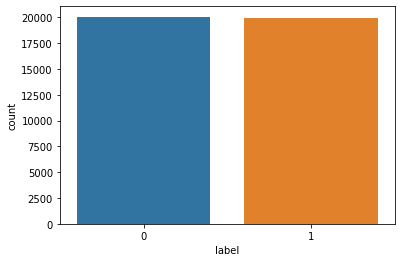

In [23]:
sns.countplot(x=y)
print(y.value_counts())

In [11]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [34]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer

In [46]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'û', 'ï']
stop_words = stop_words + more_stopwords

stemmer = nltk.SnowballStemmer("english")

In [47]:
def clean_text(text):
    #Make text lowercase, remove text in square brackets,remove links,remove punctuation
    #and remove words containing numbers
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [48]:
def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text

In [49]:
def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

In [50]:
def preprocessing(text):
    text = clean_text(text)
    text = remove_stopwords(text)
    text = stemm_text(text)
    return text

In [53]:
X = X.apply(preprocessing)
test.text = test.text.apply(preprocessing)

In [63]:
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer

tfidf = TfidfVectorizer(max_features=3000, stop_words='english', strip_accents='ascii', analyzer='word')
train_vector_tfidf = tfidf.fit_transform(X)
X_test_tfidf =tfidf.transform(test.text)

In [64]:
from sklearn.model_selection import train_test_split

X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_vector_tfidf.toarray(), y, test_size=0.2, random_state=42)

In [65]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [66]:
def report(model, X_valid, y_valid):
    #preds = model.predict(X_valid)
    preds = (model.predict(X_valid) > 0.5).astype('int32')
    print(classification_report(y_valid,preds))
    matrix = confusion_matrix(y_pred=preds, y_true=y_valid,)
    dis = ConfusionMatrixDisplay(confusion_matrix=matrix)
    dis.plot()
    plt.show()

In [119]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size_2 = 1000

word_tokenizer =  Tokenizer(num_words=vocab_size_2)
word_tokenizer.fit_on_texts(train.text)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

148073

In [120]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [121]:
longest_train = max(train.text, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(train.text), 
    length_long_sentence, 
    padding='post'
)
test_padded_sentences = pad_sequences(
    embed(test.text), 
    length_long_sentence,
    padding='post'
)

train_padded_sentences

array([[ 42,  21, 704, ...,   0,   0,   0],
       [ 17, 201,  52, ...,   0,   0,   0],
       [ 10,  16,   6, ...,   0,   0,   0],
       ...,
       [493,  64,   6, ...,   0,   0,   0],
       [  2,   3,  27, ...,   0,   0,   0],
       [ 10,  16,  66, ...,   0,   0,   0]], dtype=int32)

In [146]:
embeddings_dictionary = dict()

# Load GloVe 100D embeddings
with open('../Competition_NLP/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

In [123]:
embed_dim = 100
embedding_matrix = np.zeros((vocab_length, embed_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
        
embedding_matrix.shape

(148073, 100)

In [124]:
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(train_padded_sentences, y, test_size=0.2, random_state=42)

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D, BatchNormalization, GRU, Bidirectional
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [126]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0)

In [127]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size_2, output_dim=embed_dim, mask_zero=True))#,batch_input_shape=[batch_size, None]))
model.add(Bidirectional(GRU(64, activation='relu')))
model.add(Dense(64, activation='relu',kernel_regularizer=regularizers.L1L2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.9, beta_2=0.999), loss='binary_crossentropy', metrics=['accuracy']) 

In [128]:
model.fit(X_train_p, y_train_p,
         validation_data=[X_valid_p,y_valid_p],
         epochs=10,
         verbose=1,
         batch_size = 100,
         callbacks=[early_stop])

Epoch 1/10
320/320 [==============================] - 834s 3s/step - loss: 6.1757 - accuracy: 0.5273 - val_loss: 3.9751 - val_accuracy: 0.5930
Epoch 2/10
320/320 [==============================] - 808s 3s/step - loss: 2.5489 - accuracy: 0.5997 - val_loss: 1.4349 - val_accuracy: 0.7216
Epoch 3/10
320/320 [==============================] - 816s 3s/step - loss: 0.9222 - accuracy: 0.7154 - val_loss: 0.5694 - val_accuracy: 0.7935
Epoch 4/10
320/320 [==============================] - 781s 2s/step - loss: 0.6480 - accuracy: 0.6873 - val_loss: 0.5963 - val_accuracy: 0.7484
Epoch 5/10
320/320 [==============================] - 739s 2s/step - loss: 0.6006 - accuracy: 0.7404 - val_loss: 0.7405 - val_accuracy: 0.5049
Epoch 6/10
320/320 [==============================] - 741s 2s/step - loss: 0.6349 - accuracy: 0.6786 - val_loss: 0.5226 - val_accuracy: 0.8036
Epoch 7/10
320/320 [==============================] - 770s 2s/step - loss: 0.5245 - accuracy: 0.7962 - val_loss: 0.6235 - val_accuracy: 0.7322

250/250 [==============================] - 100s 395ms/step
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      4042
           1       0.83      0.85      0.84      3958

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



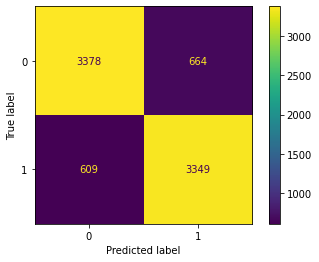

In [129]:
report(model, X_valid_p, y_valid_p)

In [137]:
prediction_nn = (model.predict(test_padded_sentences)>0.5).astype('int')

313/313 [==============================] - 107s 343ms/step


In [67]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train_tfidf)

MultinomialNB()

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      4042
           1       0.83      0.85      0.84      3958

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



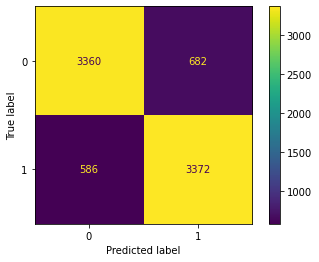

In [68]:
report(nb, X_valid_tfidf, y_valid_tfidf)

In [69]:
prediction_nb = nb.predict(X_test_tfidf)

In [138]:
final =  pd.read_csv('./test_data.csv', index_col='Id')
final['Prediction NB'] = prediction_nb
final['Prediction NN'] = prediction_nn

In [139]:
final

,text,Prediction NB,Prediction NN
Id,,,
0,What can possibly said about this movie other ...,0,0
1,I dont care how many bad reviews purple rain g...,1,0
2,Ken Russell directed this weird Not very ero...,0,0
3,This is a great movie from the lost age of rea...,1,1
4,I have a problem with the movie snobs who cons...,1,1
...,...,...,...
9995,I first saw this on Thames television and love...,1,1
9996,There are rumours that a fourth Underworld is ...,0,0
9997,Jag är nyfiken Yellow is a lot of fun Like at...,1,1


In [144]:
submission =  pd.DataFrame(index=final.index, data=prediction_nn, columns=['Prediction NN'])
submission

,Prediction NN
Id,
0,0
1,0
2,0
3,1
4,1
...,...
9995,1
9996,0
9997,1


In [145]:
submission.to_csv('submission.csv')